In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

In [7]:
X_train = np.load('X_train.npy')  
y_train = np.load('y_train.npy')  
X_val = np.load('X_val.npy')     
y_val = np.load('y_val.npy')     
X_test = np.load('X_test.npy')    
y_test = np.load('y_test.npy')  

In [8]:
X_train.shape

(336, 3, 13)

In [9]:
scaler = joblib.load('scaler.pkl')
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)       
X_test_flat = X_test.reshape(X_test.shape[0], -1)  

In [10]:
X_train_flat.shape

(336, 39)

In [11]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',  
    random_state=42
)


In [12]:
model.fit(
    X_train_flat, y_train,
    eval_set=[(X_train_flat, y_train), (X_val_flat, y_val)],
    verbose=True
)

[0]	validation_0-rmse:0.19466	validation_1-rmse:0.29789
[1]	validation_0-rmse:0.17869	validation_1-rmse:0.27868
[2]	validation_0-rmse:0.16385	validation_1-rmse:0.26581
[3]	validation_0-rmse:0.15138	validation_1-rmse:0.25376
[4]	validation_0-rmse:0.13944	validation_1-rmse:0.24391
[5]	validation_0-rmse:0.12890	validation_1-rmse:0.23487
[6]	validation_0-rmse:0.11916	validation_1-rmse:0.22262
[7]	validation_0-rmse:0.11074	validation_1-rmse:0.21736
[8]	validation_0-rmse:0.10364	validation_1-rmse:0.21259
[9]	validation_0-rmse:0.09681	validation_1-rmse:0.20678
[10]	validation_0-rmse:0.09056	validation_1-rmse:0.20286
[11]	validation_0-rmse:0.08474	validation_1-rmse:0.19541
[12]	validation_0-rmse:0.07971	validation_1-rmse:0.19003
[13]	validation_0-rmse:0.07495	validation_1-rmse:0.18866
[14]	validation_0-rmse:0.07072	validation_1-rmse:0.18669
[15]	validation_0-rmse:0.06681	validation_1-rmse:0.18260
[16]	validation_0-rmse:0.06364	validation_1-rmse:0.18112
[17]	validation_0-rmse:0.06047	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
y_train_pred = model.predict(X_train_flat)
y_val_pred = model.predict(X_val_flat)
y_test_pred = model.predict(X_test_flat)

In [14]:
def inverse_transform_pm25(scaled_values, scaler):
    dummy = np.zeros((len(scaled_values), scaler.n_features_in_))
    dummy[:, 0] = scaled_values  
    return scaler.inverse_transform(dummy)[:, 0]

y_train_true = inverse_transform_pm25(y_train, scaler)
y_train_pred = inverse_transform_pm25(y_train_pred, scaler)
y_val_true = inverse_transform_pm25(y_val, scaler)
y_val_pred = inverse_transform_pm25(y_val_pred, scaler)
y_test_true = inverse_transform_pm25(y_test, scaler)
y_test_pred = inverse_transform_pm25(y_test_pred, scaler)

In [15]:
def compute_metrics(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{dataset_name} R2: {r2:.2f} µg/m³")
    print(f"{dataset_name} RMSE: {rmse:.2f} µg/m³")
    print(f"{dataset_name} MAE: {mae:.2f} µg/m³")
    return r2,rmse, mae

train_r2, train_rmse, train_mae = compute_metrics(y_train_true, y_train_pred, "Train")
val_r2, val_rmse, val_mae = compute_metrics(y_val_true, y_val_pred, "Validation")
test_r2, test_rmse, test_mae = compute_metrics(y_test_true, y_test_pred, "Test")

Train R2: 1.00 µg/m³
Train RMSE: 0.75 µg/m³
Train MAE: 0.57 µg/m³
Validation R2: 0.24 µg/m³
Validation RMSE: 13.94 µg/m³
Validation MAE: 11.26 µg/m³
Test R2: -0.07 µg/m³
Test RMSE: 9.14 µg/m³
Test MAE: 7.30 µg/m³


In [16]:
joblib.dump(model, 'xgboost_model.pkl')


['xgboost_model.pkl']

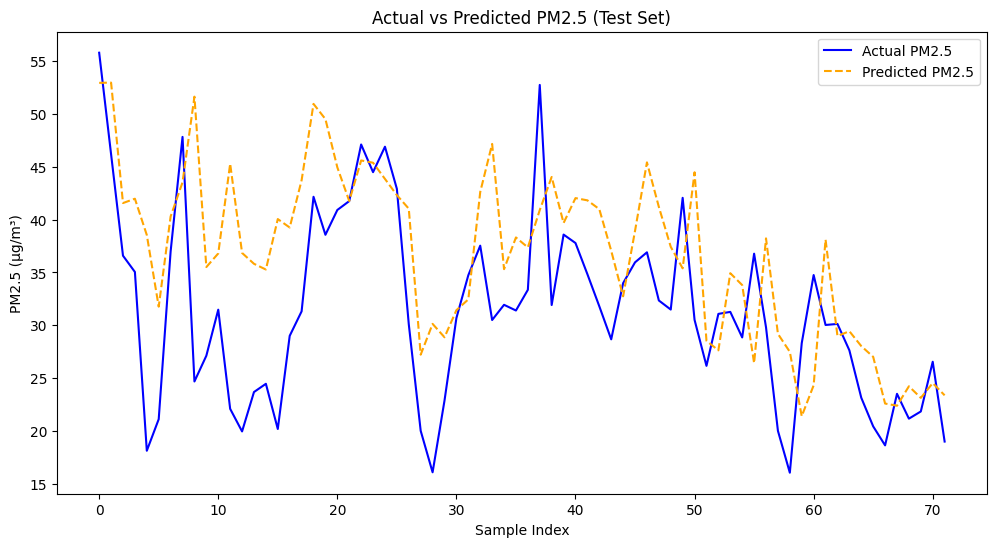

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_true, label='Actual PM2.5', color='blue')
plt.plot(y_test_pred, label='Predicted PM2.5', color='orange', linestyle='--')
plt.title('Actual vs Predicted PM2.5 (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()
plt.close()